----
# QDA classification using sklearn

----

In [243]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import confusion_matrix as skconfmatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

# Import files from /Python directory
from confusion_matrix import confusion_matrix
"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [244]:
config = {
    "standardize" : True,
    "lda-reduce" : False,
    "classifier" : "svm",
    "keep_features" : 8,
}

In [245]:
# Use noisy data sets
noise = False

# Load data sets
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_{'' if noise else 'no'}noise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_{'' if noise else 'no'}noise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_{'' if noise else 'no'}noise_100.csv")

# Separate into data and targets
y_trn = trn_data.pop('target')
X_trn = trn_data

y_vld = vld_data.pop('target')
X_vld = vld_data

y_tst = tst_data.pop('target')
X_tst = tst_data

## Standardize data (z-norm)

In [246]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst

In [247]:
import lda

reducer = lda.reducer(X_trn_std,y_trn,5)

Conditioning of Sw : 60654.49
Preserving 99.28% of variance


In [248]:

def feature_conditioner(X):
    removal = []
    conditioning = [np.linalg.cond(X.cov())]
    for i in range(len(X.columns)-1):
        conds = {}
        for feature in X.columns:
            if feature not in removal:
                temp = removal.copy()
                temp.append(feature)
                conds[feature] = np.linalg.cond(X.cov().drop(columns=temp))
        removal.append(min(conds))
        conditioning.append(np.linalg.cond(X.cov().drop(columns=removal)))
    return removal,conditioning

removal,conditioning = feature_conditioner(X_trn_std)

Text(0, 0.5, 'Log10 conditioning number')

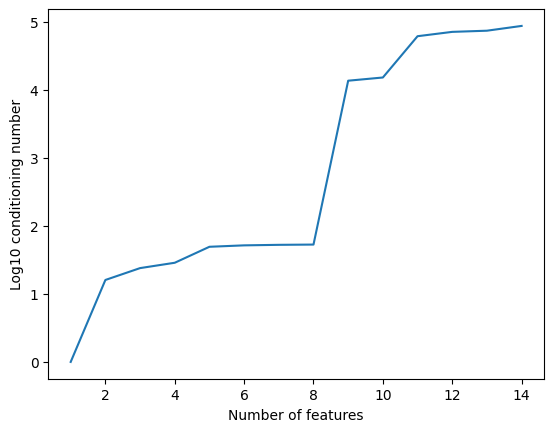

In [249]:

plt.plot( np.flip([x for x in range(1,(len(conditioning)+1))]), np.log10(conditioning) )
plt.xlabel("Number of features")
plt.ylabel("Log10 conditioning number")

In [250]:

if config["keep_features"] != False:
    X_trn_drop = X_trn_std.drop(columns = removal[0:14-config["keep_features"]])
    X_vld_drop = X_vld_std.drop(columns = removal[0:14-config["keep_features"]])
    X_tst_drop = X_tst_std.drop(columns = removal[0:14-config["keep_features"]])
    X_trn_drop.head()
else:
    X_trn_drop = X_trn_std
    X_vld_drop = X_vld_std
    X_tst_drop = X_tst_std

In [256]:
import lda

reducer = lda.reducer(X_trn_std,y_trn,5)
reducer = lda.reducer(X_trn_drop,y_trn,5)

X_trn_red = reducer.transform(X_trn_drop)
X_tst_red = reducer.transform(X_tst_drop)
X_vld_red = reducer.transform(X_vld_drop)

Conditioning of Sw : 60654.49
Preserving 99.28% of variance
Conditioning of Sw : 172.09
Preserving 99.95% of variance


---

# Train classifiers

In [257]:

if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_vld_red,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_vld_red,y_trn)
    
elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    clf.fit(X_vld_red,y_trn)

# Classifying training data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Full-SVM : 8 features of training set : Accuracy 89.056%'}, xlabel='Predicted class', ylabel='True class'>)

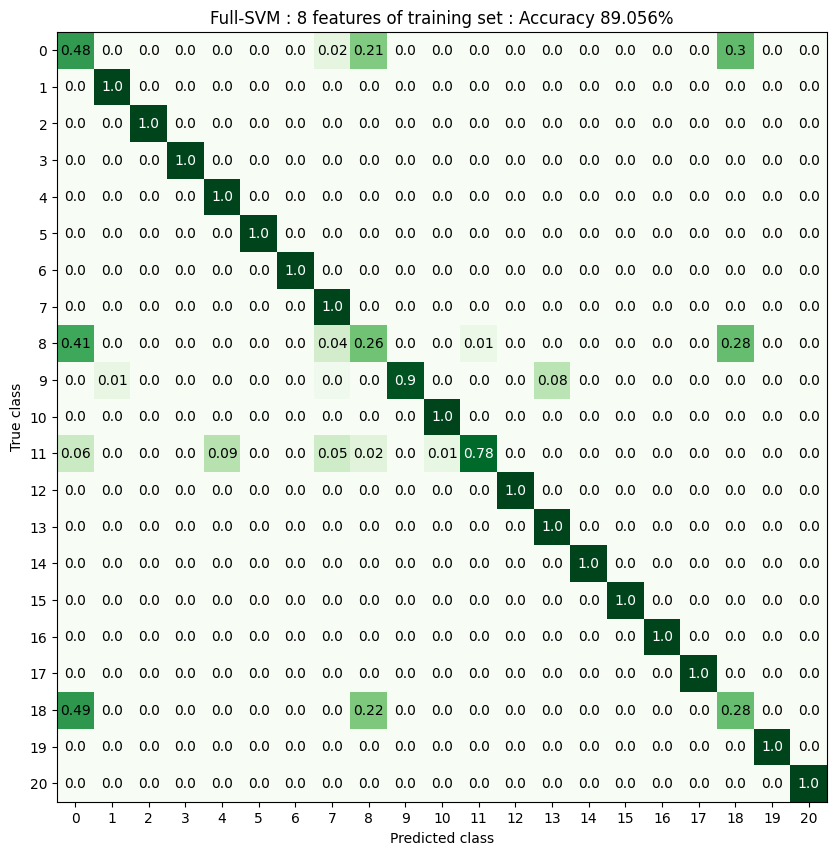

In [258]:
# Make predictions for the training set
y_hat_trn = clf.predict(X_trn_red)

#plot the confusion matrix
conf_matrix_trn = skconfmatrix(y_trn,y_hat_trn)
confusion_matrix(
    conf_matrix_trn,
    figsize = (10,10),
    title = f'{f"LDA{x}" if (x:=config["lda-reduce"]) else "Full"}-{str(config["classifier"]).upper()} : {config["keep_features"]} features of training set',
    save_fig_name = f'{f"LDA{x}" if (x:=config["lda-reduce"]) else "Full"}-{str(config["classifier"]).upper()}-{config["keep_features"]}f-training.pdf')

# Classifying validation data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Full-QDA 14d on validation set : Accuracy 89.044%'}, xlabel='Predicted class', ylabel='True class'>)

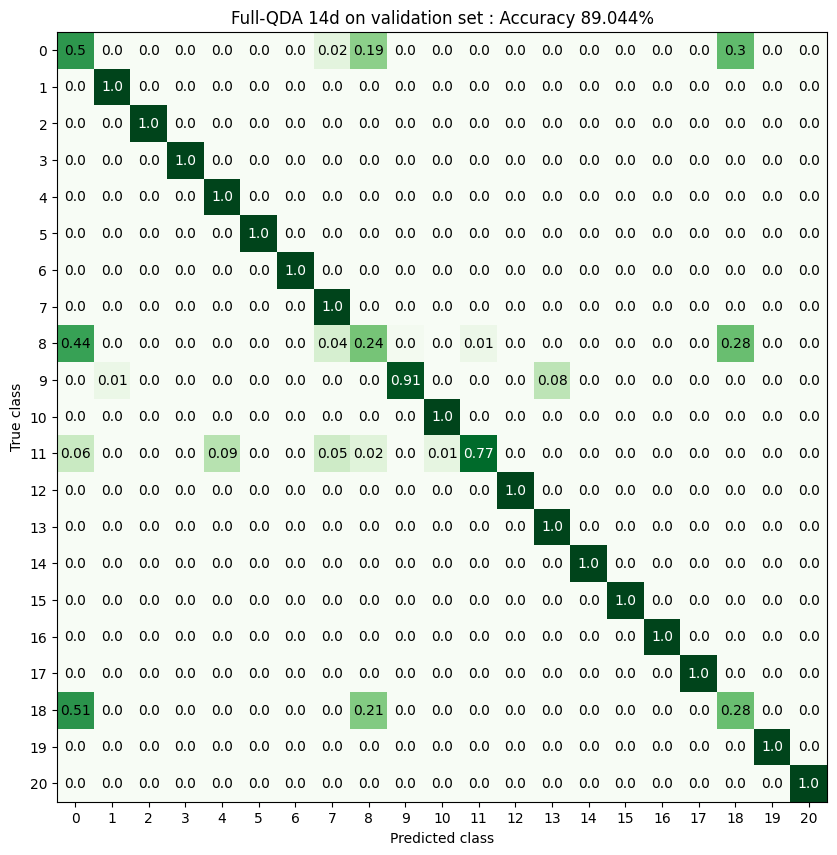

In [259]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld_red)

#plot the confusion matrix
conf_matrix_vld = skconfmatrix(y_vld,y_hat_vld)
confusion_matrix(conf_matrix_vld, figsize = (10,10),title='Full-QDA 14d on validation set', save_fig_name='Full-QDA 14d validation data confusion matrix.pdf')

# Classifying test data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Full-QDA 14d on test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

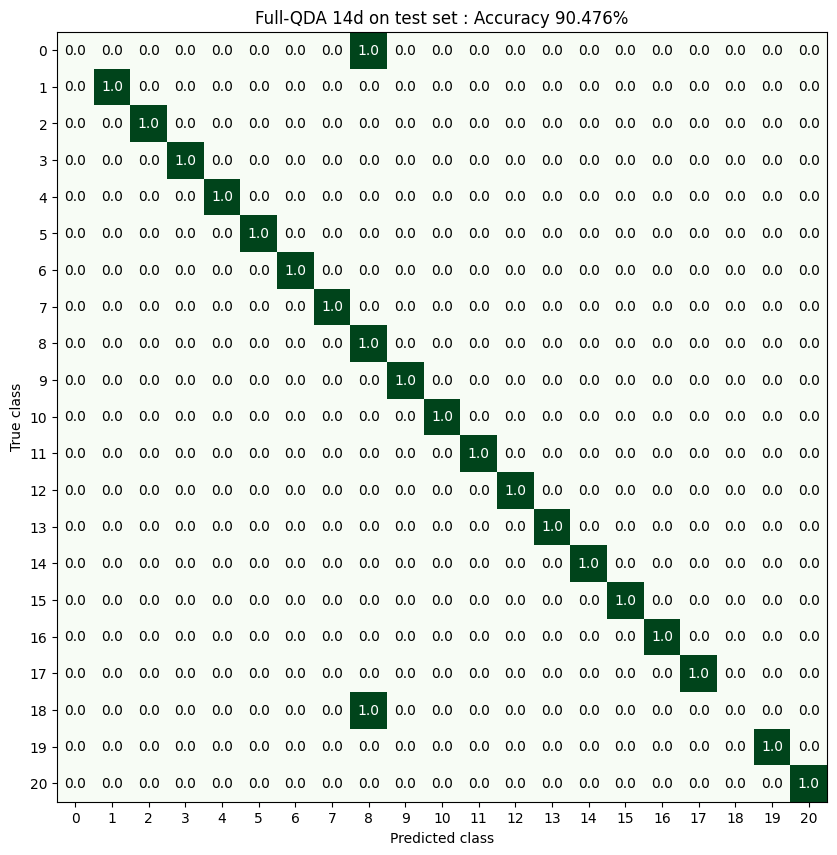

In [260]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst_red)

#plot the confusion matrix
conf_matrix_vld = skconfmatrix(y_tst,y_hat_tst)
confusion_matrix(conf_matrix_vld, figsize = (10,10),title='Full-QDA 14d on test set', save_fig_name='Full-QDA 14d test confusion matrix.pdf')